# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

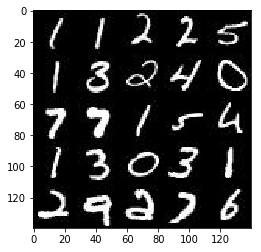

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
import numpy as np
import matplotlib
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

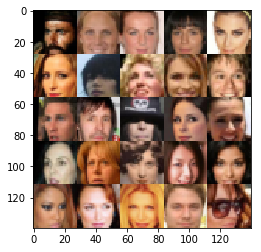

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels,))
    z_dim = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, ())

    return input_image, z_dim, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [70]:
def discriminator(images, reuse=False, alpha=0.2, is_train=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.layers.dropout(flat, rate=0.4)
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.4)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [71]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x256 
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same',
                                       )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14X14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',
                                       )
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28X64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                            )
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [72]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [73]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
        
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [79]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
           print_every=50, show_every=150):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
              :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,  data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *=2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')
    

                
               
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.4182
Epoch 1/2... Discriminator Loss: 1.6947... Generator Loss: 0.2576
Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 0.5772


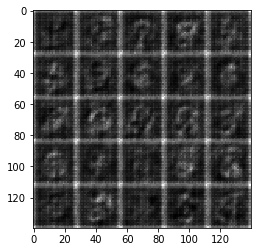

Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 1.7708
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.5475
Epoch 1/2... Discriminator Loss: 0.7349... Generator Loss: 1.5447


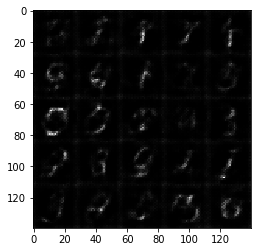

Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 2.2251
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 1.2751
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 2.3109


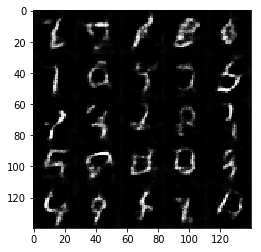

Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 0.4773


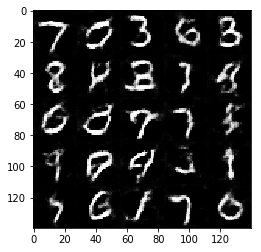

Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.3260
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 0.9249
Epoch 1/2... Discriminator Loss: 0.7573... Generator Loss: 1.2241


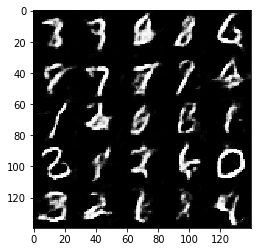

Epoch 1/2... Discriminator Loss: 1.9864... Generator Loss: 0.2059
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.1548
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 0.6083


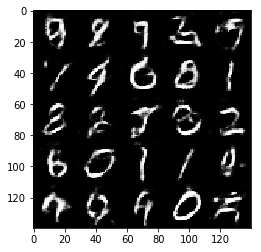

Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 0.8074


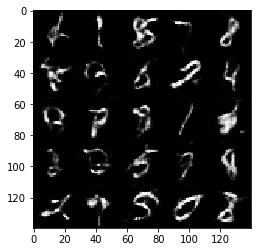

Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 1.3378
Epoch 2/2... Discriminator Loss: 1.6184... Generator Loss: 2.6471
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.0335


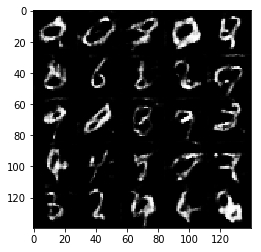

Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 1.0628
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 0.3341
Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 2.6494


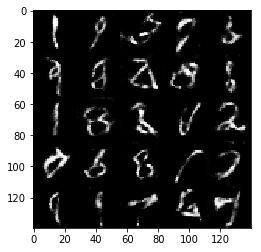

Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 1.0078
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 0.5997


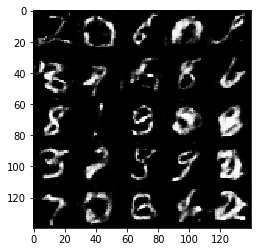

Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 0.6886
Epoch 2/2... Discriminator Loss: 1.0131... Generator Loss: 0.7082


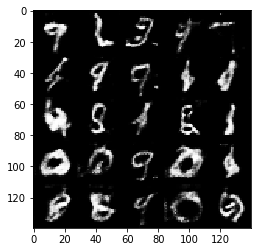

Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.2224
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.4246
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.1342


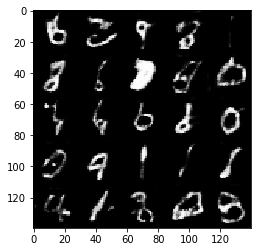

Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 0.8060


In [80]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW /THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2938... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.5254


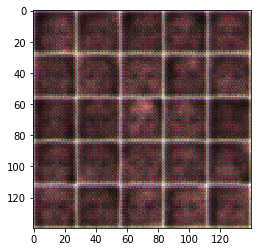

Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 2.0233
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 0.7243


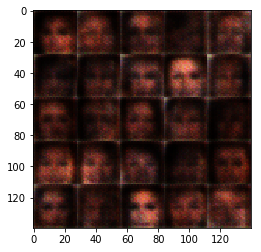

Epoch 1/1... Discriminator Loss: 0.2764... Generator Loss: 2.3008
Epoch 1/1... Discriminator Loss: 0.2886... Generator Loss: 2.7263
Epoch 1/1... Discriminator Loss: 0.2609... Generator Loss: 2.0236


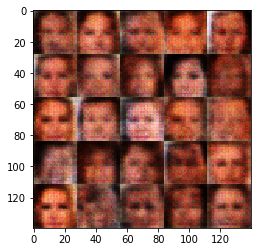

Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 1.9838
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 0.7626


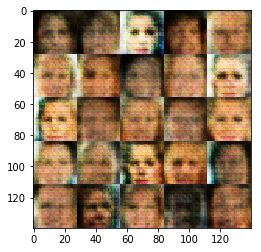

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.5063
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 3.7349
Epoch 1/1... Discriminator Loss: 2.0320... Generator Loss: 0.1839


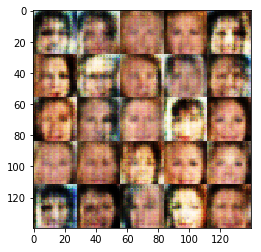

Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 2.9881
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 5.8392
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 3.7018


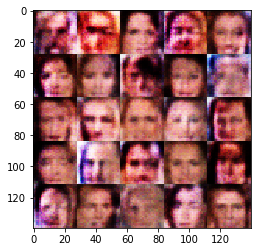

Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 2.0849
Epoch 1/1... Discriminator Loss: 0.0877... Generator Loss: 4.8243


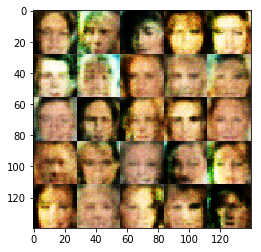

Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 2.1826
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 7.3840


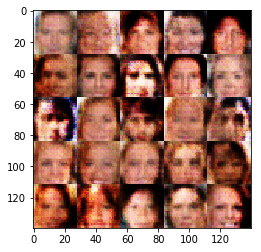

Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 4.6839
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.3797


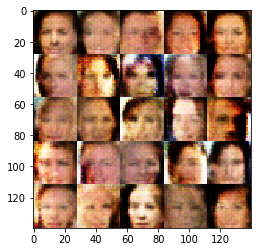

Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 2.3766
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 5.7111
Epoch 1/1... Discriminator Loss: 0.2044... Generator Loss: 2.5170


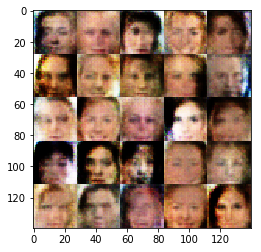

Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 2.8326
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 3.6105
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.4609


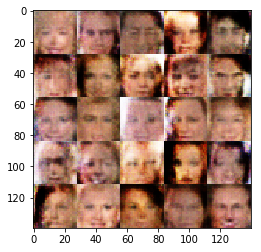

Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 0.1252... Generator Loss: 3.6020


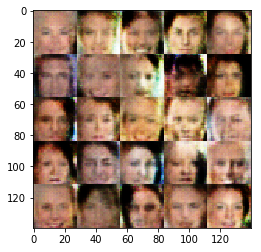

Epoch 1/1... Discriminator Loss: 0.1303... Generator Loss: 3.1114
Epoch 1/1... Discriminator Loss: 0.0716... Generator Loss: 5.7939
Epoch 1/1... Discriminator Loss: 0.1138... Generator Loss: 5.0223


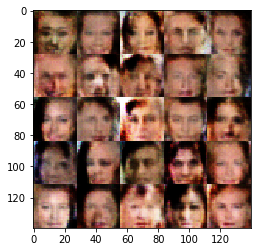

Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 2.6270
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 3.0586


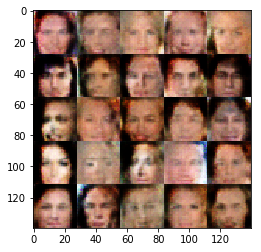

Epoch 1/1... Discriminator Loss: 0.0706... Generator Loss: 4.6297
Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 3.5811
Epoch 1/1... Discriminator Loss: 0.1477... Generator Loss: 3.9483


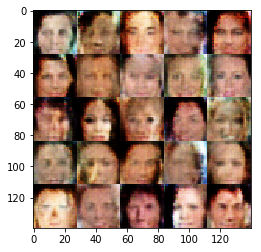

Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 3.5721
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 3.9820


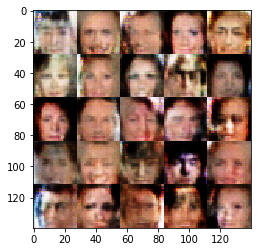

Epoch 1/1... Discriminator Loss: 3.0332... Generator Loss: 3.1963
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 3.8420
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 2.8928


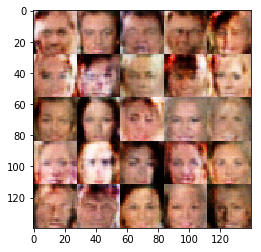

Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 3.0305
Epoch 1/1... Discriminator Loss: 0.3788... Generator Loss: 5.5713
Epoch 1/1... Discriminator Loss: 0.0679... Generator Loss: 5.8229


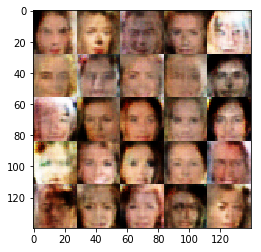

Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 2.4672
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 4.7987
Epoch 1/1... Discriminator Loss: 0.1744... Generator Loss: 2.3926


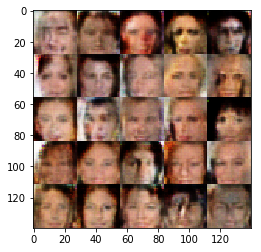

Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 3.3970
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 3.5503
Epoch 1/1... Discriminator Loss: 3.5704... Generator Loss: 0.0559


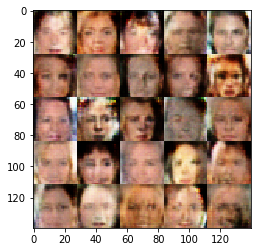

Epoch 1/1... Discriminator Loss: 0.0530... Generator Loss: 5.7361
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 5.0883
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 3.1713


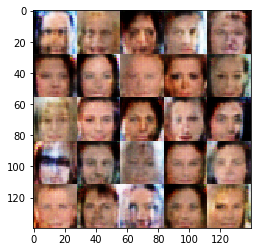

Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 0.2187... Generator Loss: 3.4859
Epoch 1/1... Discriminator Loss: 0.1696... Generator Loss: 2.6348


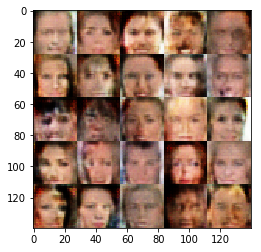

Epoch 1/1... Discriminator Loss: 0.0988... Generator Loss: 2.9844
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 3.4673


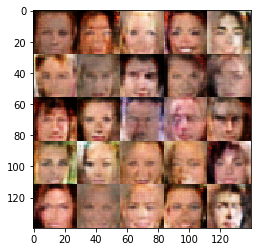

Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 2.5637
Epoch 1/1... Discriminator Loss: 0.0817... Generator Loss: 4.1697
Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 3.1169


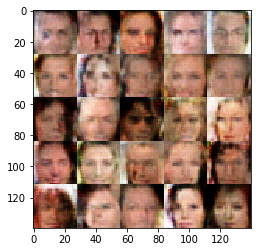

Epoch 1/1... Discriminator Loss: 0.3065... Generator Loss: 3.6872
Epoch 1/1... Discriminator Loss: 0.0646... Generator Loss: 5.1936
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 3.0386


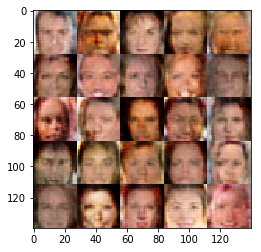

Epoch 1/1... Discriminator Loss: 0.1248... Generator Loss: 5.7972
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 3.8165
Epoch 1/1... Discriminator Loss: 0.1734... Generator Loss: 3.0427


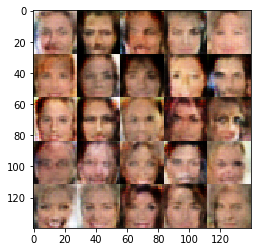

Epoch 1/1... Discriminator Loss: 0.0524... Generator Loss: 5.0781
Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 4.1375
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 1.9571


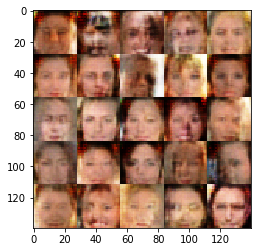

Epoch 1/1... Discriminator Loss: 0.1401... Generator Loss: 6.2745
Epoch 1/1... Discriminator Loss: 0.0764... Generator Loss: 3.3222
Epoch 1/1... Discriminator Loss: 0.1737... Generator Loss: 2.3150


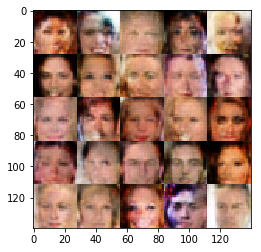

Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 3.5838
Epoch 1/1... Discriminator Loss: 0.0810... Generator Loss: 3.3429
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.3872


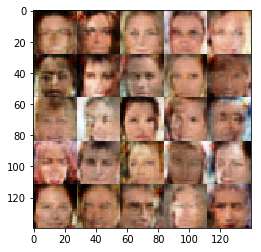

Epoch 1/1... Discriminator Loss: 0.1468... Generator Loss: 2.5717
Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 4.3733
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 4.4141


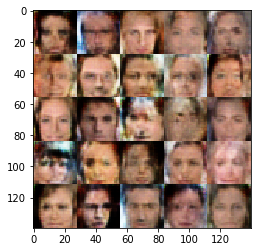

Epoch 1/1... Discriminator Loss: 0.0772... Generator Loss: 3.5583
Epoch 1/1... Discriminator Loss: 0.0585... Generator Loss: 3.7558
Epoch 1/1... Discriminator Loss: 0.0897... Generator Loss: 4.3056


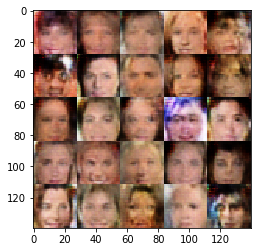

Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 2.5905
Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 2.0240
Epoch 1/1... Discriminator Loss: 0.1292... Generator Loss: 2.8934


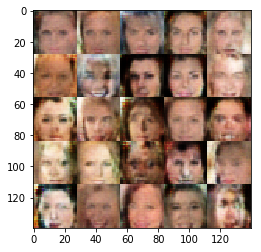

Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.9024
Epoch 1/1... Discriminator Loss: 0.3117... Generator Loss: 1.8397
Epoch 1/1... Discriminator Loss: 0.1972... Generator Loss: 2.3954


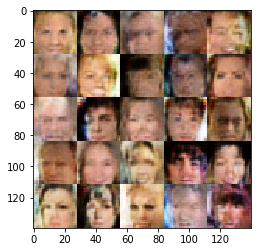

Epoch 1/1... Discriminator Loss: 0.1294... Generator Loss: 2.9515
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 5.9309
Epoch 1/1... Discriminator Loss: 0.1589... Generator Loss: 4.3435


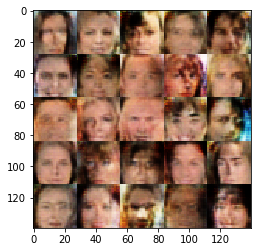

Epoch 1/1... Discriminator Loss: 0.0967... Generator Loss: 4.1312
Epoch 1/1... Discriminator Loss: 0.1293... Generator Loss: 2.8019
Epoch 1/1... Discriminator Loss: 0.1221... Generator Loss: 4.5071


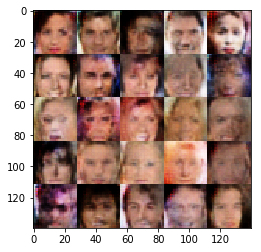

Epoch 1/1... Discriminator Loss: 0.1862... Generator Loss: 2.2155
Epoch 1/1... Discriminator Loss: 0.1451... Generator Loss: 2.9813
Epoch 1/1... Discriminator Loss: 0.0349... Generator Loss: 7.2226


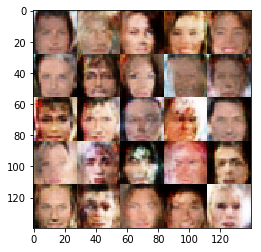

Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 4.1708
Epoch 1/1... Discriminator Loss: 0.2545... Generator Loss: 7.2235
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 4.5626


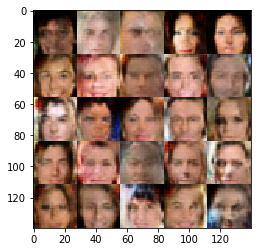

Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 3.6794
Epoch 1/1... Discriminator Loss: 0.0605... Generator Loss: 4.8227
Epoch 1/1... Discriminator Loss: 0.0751... Generator Loss: 3.4627


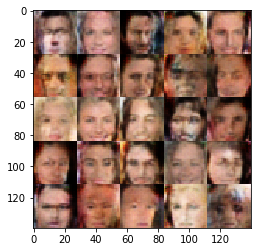

Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 2.2106
Epoch 1/1... Discriminator Loss: 0.3129... Generator Loss: 2.0027
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.0811


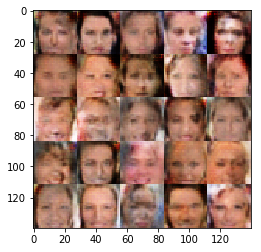

Epoch 1/1... Discriminator Loss: 0.1695... Generator Loss: 2.2924
Epoch 1/1... Discriminator Loss: 0.0942... Generator Loss: 3.4130
Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 4.5922


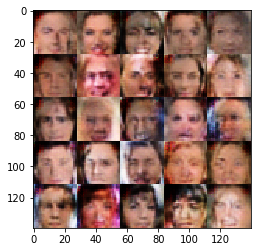

Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 4.8299
Epoch 1/1... Discriminator Loss: 0.0440... Generator Loss: 5.0030
Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 2.5555


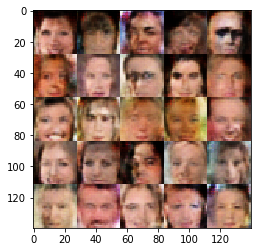

Epoch 1/1... Discriminator Loss: 0.0923... Generator Loss: 3.1802
Epoch 1/1... Discriminator Loss: 0.0784... Generator Loss: 5.1513
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 3.7305


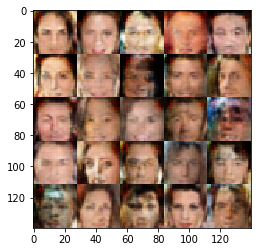

In [81]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.